# 无需分类器的生成引导

> 作者本文使用的notation是比较不同的，故在此说明，文中的公式我既会从概率分布角度出发推导也会从去噪得分匹配角度出发推导。
>
> 在下面的推导中，我会使用 $\sim$ 上标来标记带超参数 $s$ 的分布函数或去噪函数，这一点与原文的符号习惯一样。

## CLASSIFIER DIFFUSION GUIDANCE

在 Score-Based 那篇笔记中，我们在最后提出了如下公式
$$\nabla_{\mathbf{x}}\log p(\mathbf{x}\mid\mathbf{y})=\nabla_{\mathbf{x}}\log p(\mathbf{x})+\nabla_{\mathbf{x}}\log p(\mathbf{y}\mid\mathbf{x})-[\nabla_{\mathbf{x}}\log p(\mathbf{y})]=\underbrace{\nabla_{\mathbf{x}}\log p(\mathbf{x})}_{得分函数}+\underbrace{\nabla_{\mathbf{x}}\log p(\mathbf{y}\mid\mathbf{x}}_{分类器})$$

即对于每个时间步：$$\underbrace{\nabla_{\mathbf{x_t}}\log p(\mathbf{x_t})}_{得分函数}+\underbrace{\nabla_{\mathbf{x_t}}\log p(\mathbf{y}\mid\mathbf{x_t}}_{分类器})$$

前者可以由训练好的无条件模型直接得到，而后者则需要额外训练一个分类神经网络，接受每个时间步的噪声图像输入并进行分类。为了控制生成的过程，我们引入超参数 $s$ 调节条件信息的强度：
$$\underbrace{\nabla_{\mathbf{x}}\log \tilde{p}(\mathbf{x}\mid\mathbf{y})}_{条件生成器}=\underbrace{\nabla_{\mathbf{x_t}}\log p(\mathbf{x_t})}_{得分函数}+s~~\underbrace{\nabla_{\mathbf{x_t}}\log p(\mathbf{y}\mid\mathbf{x_t}}_{分类器})$$

### 引入参数 $s$ 的作用
根据推导，引入超参数后，条件生成器 $\tilde p(x|y) = p(x)p(y|x)^{s}=p(x|y)p(y|x)^{s-1}$

即原条件生成器乘上了 $s-1$ 次幂的条件分类函数，当 $s$ 取大整数时，$\tilde p$ 的密度会集中于条件密度函数的峰值处。下图展示了这种对数密度的关系：

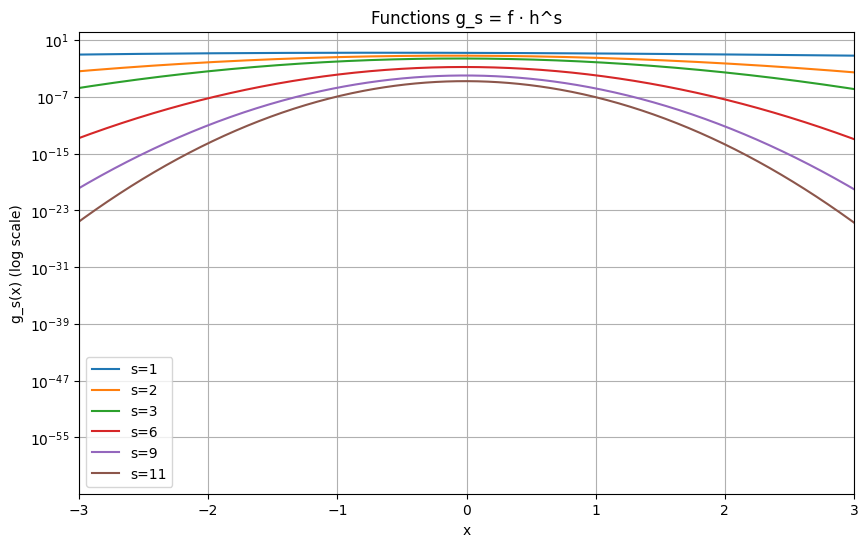

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 生成数据点
x = np.linspace(-5, 5, 1000)

# 计算混合分布 f
f = 0.3 * norm.pdf(x, loc=2, scale=np.sqrt(6)) + 0.7 * norm.pdf(x, loc=-1, scale=2)

# 计算标准正态分布 h
h = norm.pdf(x, loc=0, scale=1)

# 绘制函数列 g_n
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
times = [0, 1, 2, 5, 8, 10]
for n in range(1, 7):
    g_n = f * (h ** times[n-1])
    plt.plot(x, g_n, label=f's={times[n-1]+1}', color=colors[n-1])

plt.xlim(-3, 3)
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('g_s(x) (log scale)')
plt.title('Functions g_s = f · h^s')
plt.legend()
plt.grid(True)
plt.show()

### 原文的解释

在原文的符号表示中，$c$ 代表条件，$z_{\lambda}$ 代表反向过程的恢复图像，$\lambda$ 越小则噪声越大，时间步越小。

本文采用类似于 Score-Based 去噪得分匹配的方法，其损失函数与扩散模型中的噪声预测形式是一致的，即：
$$\epsilon_{\theta}(\mathbf{z}_{\lambda}, \mathbf{c}) \approx -\sigma_{\lambda} \nabla_{\mathbf{z}_{\lambda}} \log p(\mathbf{z}_{\lambda}|\mathbf{c})$$
令 $c=\varnothing$，则上式变为：
$$\epsilon_{\theta}(\mathbf{z}_{\lambda}) \approx -\sigma_{\lambda} \nabla_{\mathbf{z}_{\lambda}} \log p(\mathbf{z}_{\lambda})$$
即无条件情况下的噪声匹配。

当引入超参数 $s$ 后（s-1与s只是形式上的差异，这里不再区分）
$$\tilde\epsilon_{\theta}(\mathbf{z}_{\lambda}, \mathbf{c})=
-\sigma_{\lambda} \nabla_{\mathbf{z}_{\lambda}} \left[ \log p(\mathbf{z}_{\lambda}|\mathbf{c}) + s \log p_{\theta}(\mathbf{c}|\mathbf{z}_{\lambda}) \right]=\epsilon_{\theta}(\mathbf{z}_{\lambda}, \mathbf{c})-\sigma_{\lambda} \nabla_{\mathbf{z}_{\lambda}}s\log p_{\theta}(\mathbf{c}|\mathbf{z}_{\lambda}) $$

因此我们在训练时，既要训练一个条件去噪神经网络，也要训练一个分类神经网络。

## 无分类器引导

### 数学原理

我们从超参数的条件生成器出发：
$$\underbrace{\nabla_{\mathbf{x}}\log \tilde{p}(\mathbf{x}\mid\mathbf{y})}_{条件生成器}=\underbrace{\nabla_{\mathbf{x_t}}\log p(\mathbf{x_t})}_{得分函数}+s~~\underbrace{\nabla_{\mathbf{x_t}}\log p(\mathbf{y}\mid\mathbf{x_t}}_{分类器})$$

这里我们想要去掉分类器，因此对不含超参数的条件生成器进行修改：
$$\nabla_{\mathbf{x_t}}\log p(\mathbf{y}\mid\mathbf{x_t})=\nabla_{\mathbf{x}}\log p(\mathbf{x}\mid\mathbf{y})-\nabla_{\mathbf{x_t}}\log p(\mathbf{x_t})$$

代入上式得：
$$\nabla_{\mathbf{x}}\log \tilde{p}(\mathbf{x}\mid\mathbf{y}) = (1-s)\nabla_{\mathbf{x_t}}\log p(\mathbf{x_t})+s\nabla_{\mathbf{x}}\log p(\mathbf{x}\mid\mathbf{y})$$

改写为论文中的符号形式
$$\tilde\epsilon_{\theta}(\mathbf{z}_{\lambda}, \mathbf{c})=(1-s)\epsilon_{\theta}(\mathbf{z}_{\lambda})+s~\epsilon_{\theta}(\mathbf{z}_{\lambda}, \mathbf{c})$$

然后令 $s=1+w$，就化得
$$
\tilde{\boldsymbol{\epsilon}}_{\theta}(\mathbf{z}_{\lambda}, \mathbf{c}) = (1 + w) \boldsymbol{\epsilon}_{\theta}(\mathbf{z}_{\lambda}, \mathbf{c}) - w \boldsymbol{\epsilon}_{\theta}(\mathbf{z}_{\lambda})
$$
这就是原文的公式$(6)$。

因此我们成功消掉了条件分类器，只需要训练一个参数化神经网络 $\epsilon_{\lambda}(\mathbf{z_{\lambda}, \mathbf c})$，其中 $\mathbf c=\varnothing$ 时为非条件噪声预测网络。

### ALGORITHM $I$ ：训练算法

引入超参数 $p_{\text{uncond}}$ 作为概率，在训练循环中，将样本 $(\mathbf x,\mathbf c)$ 随机置为无条件 $\mathbf c = \varnothing$，并在损失函数中采用我们上述推导出的噪声预测网络 $\tilde \epsilon$ 。

该算法实现了同时训练一个既能处理条件去噪又能处理非条件去噪的神经网络，其他步骤没有特别之处。

### ALGORITHM $II$ ：采样算法

从 $\mathcal N(0,I)$ 中采样，然后根据公式$(6)$进行引导

### 条件注入
在 LDM 中实现了